# Analysis of stromal cells (all non-cancer cells) from experiments 1 and 2 

This notebook provides example scripts for accessing and analyzing stromal cell data from both experiments, and generates the cell type annotation results in Figures 2 and S2.

# Preparation
This list includes the necessary packages to run the notebook, along with some that may not be required here but are commonly used for exploring adata.

In [1]:
import os
import re
import time
import glob
import csv
import seqc
import h5py
import tables
import seqc.filter
import warnings
import itertools
import harmony
import palantir as pl
import scvelo as scv
import cellrank as cr
import collections
import statsmodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import doubletdetection
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import seaborn as sns
import scrublet as scr
import anndata as ad
import networkx as nx
import logging
import scipy.cluster.hierarchy as shc
import scanpy.external as sce
import logging

from pathlib import Path
from typing import Dict
from scipy import sparse
from scipy import io
from scipy.sparse.csgraph import connected_components
from sklearn.preprocessing import normalize
from itertools import compress
from kneed import KneeLocator
from copy import deepcopy
from seqc import plot
from seqc.plot import FigureGrid
from collections import OrderedDict
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from seqc.sparse_frame import SparseFrame
from scipy.io import mmwrite
from adjustText import adjust_text

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
# Define and customize plot attributes
%matplotlib inline
sc.set_figure_params(dpi=80) 

sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = [4,4]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.style.use("ggplot")
mpl.rcdefaults()
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

logging.getLogger('matplotlib').setLevel(logging.ERROR)

# Initialize

In [3]:
# Change directory to the desired path:
DATA_DIR = '/data/massague/gans/projects/Breast_tumor/GitHub/Data/'

# Sub-directory for the stromal cell data from experiments 1 and 2
source = 'Stroma_CellType_1_2/'

# Processed adata of individual cells 
for h5_file in Path(DATA_DIR+source).glob('*filtered.h5'):   
    adata = sc.read(h5_file) 
    # adata: Log-transformed, normalized data, filtered to exclude empty droplets or low-quality droplets 
    
# Corresponding cell type-averaged expression (matching adata)
for h5_file in Path(DATA_DIR+source).glob('*CT.h5'):   
    adata_CT = sc.read(h5_file) 
    # adata: (NOT log-transformed) normalized data, averaged among cells from cell type (based on the finalized annotation)

## Mouse brain atlas reference

Here we load in the reference data and annotations as downloaded from http://mousebrain.org/adolescent/, and need to convert formats for features like gene names to match our adata.

In [47]:
# Change directory to the desired path, where references are stored
REF_DIR = '/data/massague/gans/projects/Breast_tumor/GitHub/Reference/'

# Sub-directory for the mouse brain atlas
ref = 'Mouse_Brain_Atlas/'

for loom_file in Path(REF_DIR+ref).glob('*.loom'):    
    atlas = sc.read_loom(loom_file) 
    
atlas.obs_names = atlas.obs['ClusterName']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Rows, reference clusters; columns, gene names.

In [99]:
atlas

AnnData object with n_obs × n_vars = 265 × 27930
    obs: 'Age_6w', 'Age_?', 'Age_p12, p35', 'Age_p16, p24', 'Age_p19', 'Age_p19, p21', 'Age_p20', 'Age_p21', 'Age_p21, p23', 'Age_p21-23', 'Age_p22', 'Age_p22-24', 'Age_p23', 'Age_p24', 'Age_p25', 'Age_p25-27', 'Age_p26', 'Age_p27', 'Age_p28', 'Age_p29', 'Age_p30', 'Age_p60', 'Bucket', 'Class', 'ClusterName', 'ClusterScore', 'Clusters', 'Comment', 'Description', 'Developmental_compartment', 'LeafOrder', 'Location_based_on', 'MarkerGenes', 'MarkerRobustness', 'MarkerSelectivity', 'MarkerSpecificity', 'NCells', 'Neurotransmitter', 'OriginalClusters', 'Outliers', 'Probable_location', 'Region', 'SampleID_10X01_1', 'SampleID_10X02_1', 'SampleID_10X04_1', 'SampleID_10X04_2', 'SampleID_10X04_4', 'SampleID_10X05_1', 'SampleID_10X05_2', 'SampleID_10X05_3', 'SampleID_10X05_4', 'SampleID_10X06_1', 'SampleID_10X06_2', 'SampleID_10X06_3', 'SampleID_10X07_1', 'SampleID_10X11_1', 'SampleID_10X19_2', 'SampleID_10X20_1', 'SampleID_10X20_2', 'SampleID_10X

atlas contains all the necessary information to run the script, while "clusters" and "markers" are loaded separately for convenient reference to the mouse brain database.

In [49]:
atlas_cluster = pd.read_excel(REF_DIR+ref+'clusters.xlsx')
atlas_marker = pd.read_excel(REF_DIR+ref+'markers.xlsx')

In [72]:
atlas_cluster

Dendrogram order Cluster name                          Description  \
0                   0       TEGLU1  Excitatory neurons, cerebral cortex   
1                   1       TEGLU3  Excitatory neurons, cerebral cortex   
2                   2       TEGLU2  Excitatory neurons, cerebral cortex   
3                   3      TEGLU20  Excitatory neurons, cerebral cortex   
4                   4      TEGLU11  Excitatory neurons, cerebral cortex   
..                ...          ...                                  ...   
260               260         PVM1             Perivascular macrophages   
261               261         PVM2  Perivascular macrophages, activated   
262               262         MGL3                 Microglia, activated   
263               263         MGL2                 Microglia, activated   
264               264         MGL1                            Microglia   

     Region Developmental compartment  \
0    Cortex             Telencephalon   
1    Cortex             Telencephalon   
2    Cortex             Telencephalon   
3    Cortex             Telencephalon   
4    Cortex             Telencephalon   
..      ...                       ...   
260     CNS                  Mesoderm   
261     CNS                  Mesoderm   
262     CNS                  Mesoderm   
263     CNS                  Mesoderm   
264     CNS                  Mesoderm   

                                      Neurotransmitter  \
0    Glutamate (VGLUT1),Glutamate (VGLUT2),Glutamat...   
1                                   Glutamate (VGLUT1)   
2                                   Glutamate (VGLUT1)   
3                                   Glutamate (VGLUT1)   
4                                   Glutamate (VGLUT1)   
..                                                 ...   
260                                                NaN   
261                                                NaN   
262                                                NaN   
263                                                NaN   
264                                                NaN   

                                      Comment  \
0          Remaining heterogeneity for VGLUT3   
1                                         NaN   
2                                         NaN   
3    Remaining heterogeneity for Nitric oxide   
4                                         NaN   
..                                        ...   
260                                       NaN   
261                                       NaN   
262                                       NaN   
263                                       NaN   
264                                       NaN   

                                  Taxonomy_group  \
0    Telencephalon projecting excitatory neurons   
1    Telencephalon projecting excitatory neurons   
2    Telencephalon projecting excitatory neurons   
3    Telencephalon projecting excitatory neurons   
4    Telencephalon projecting excitatory neurons   
..                                           ...   
260                     Perivascular macrophages   
261                     Perivascular macrophages   
262                                    Microglia   
263                                    Microglia   
264                                    Microglia   

     Probable location (manually assigned)  
0    Cingulate/Retrosplenial area, layer 6  
1                 Cortex pyramidal layer 6  
2                Cortex pyramidal layer 6b  
3                 Cortex pyramidal layer 6  
4        Cortical pyramidal (poor markers)  
..                                     ...  
260                                    CNS  
261                                    CNS  
262                                    CNS  
263                                    CNS  
264                                    CNS  

[265 rows x 9 columns]

In [73]:
atlas_marker

Cluster ID   Unnamed: 1   Gene1  Gene2          Gene3    Gene4   Gene5
0        TEGLU1       Marker    Myl4  Cpne4          Olfm3  Gm11549  Plcxd2
1        TEGLU1  Specificity       0    0.5              1        1       1
2        TEGLU1  Selectivity       7      1              1        1       1
3        TEGLU1   Robustness       1      1              1        1       1
4        TEGLU3       Marker    Rprm  Rell1  3110035E14Rik     Tbr1  Garnl3
...         ...          ...     ...    ...            ...      ...     ...
1055       MGL2   Robustness       1      1              1        1       1
1056       MGL1       Marker  P2ry12   Ccr6          Gpr34    Trem2    Ctss
1057       MGL1  Specificity       0    0.7            0.7      0.7     0.7
1058       MGL1  Selectivity       4      1              1        1       1
1059       MGL1   Robustness       1      1              1        1       1

[1060 rows x 7 columns]

### Standardize gene name formats

1. Capitalize the gene names
2. Build a directory of the marker genes from atlas
3. Then build a directory of relevant marker genes, excluding the mitochondrial genes, ribosomal genes, and MALAT1 (highly abundant in scRNA-seq data) 
4. Note that the gene names are not all unique - need to group the counts of identical gene names 

In [50]:
atlas.var_names = [g.upper() for g in atlas.var_names]

In [51]:
atlas_MarkerGenes = {}
l_all = []

for i in atlas.obs_names:
    l = [g.upper() for g in atlas.obs['MarkerGenes'][i].split(' ')]
    l_all = l_all+l   
    atlas_MarkerGenes[i] = l

These genes are in the reference dataset but not our adata.

In [52]:
np.setdiff1d(l_all, adata.var_names)

array(['1700042O10RIK', '4833422C13RIK', '4930426D05RIK', '6330403A02RIK',
       '9230105E05RIK', 'A830036E02RIK', 'ABHD11OS', 'C130021I20RIK',
       'CALCB', 'CASR', 'CHAT', 'DEFA24', 'DLX6OS1', 'E530001K10RIK',
       'ETAA1OS', 'EVX1', 'EVX1OS', 'FEV', 'GFRA3', 'GM12144', 'GM13205',
       'GM13425', 'GM13582', 'GM13629', 'GM14964', 'GM15469', 'GM26644',
       'GM26673', 'GM27199', 'GM7271', 'GPR101', 'HOTAIRM1', 'HOXA10',
       'HOXA9', 'HOXB5OS', 'HTR3B', 'INADL', 'MHRT', 'MRGPRA3', 'NXPH2',
       'PGR15L', 'POU4F2', 'POU4F3', 'PROX1OS', 'RAB26OS', 'RLN3', 'RMST',
       'RP23-231J2.1', 'RP23-366O14.4', 'RP24-134N2.1', 'RP24-236C17.2',
       'TBX3OS1', 'UCN', 'UCN3'], dtype='<U13')

Some genes in this set appear unshared between the reference and our adata due to different aliases for the same gene. Below, we change the aliases in the reference to match those in adata:

1. '6330403A02RIK' to 'STUM'
2. 'AVP' to 'IFNAR1'
3. '2810417H13RIK' to 'PCLAF'
3. 'AMN' to 'ABCD1'
5. 'A230065H16RIK' to 'LBHD2'

In [53]:
switch = [['6330403A02RIK','STUM'],
         ['AVP','IFNAR1'],
         ['2810417H13RIK','PCLAF'],
         ['AMN','ABCD1'],
         ['A230065H16RIK','LBHD2']]

In [54]:
for k in atlas_MarkerGenes.keys():
    for s in switch:        
        atlas_MarkerGenes[k] = [s[1] if (g==s[0]) else g for g in atlas_MarkerGenes[k]]

Exclude mitochondrial (starts w/ "MT-") and ribosomal genes as marker genes, as they are highly abundant in scRNA-seq data, lack clear biological meaning, and can overwhelm the signal.

In [59]:
# Ribosomal genes
with open(REF_DIR+'ribosomal_genes.092820.csv','r') as file:
    lines = file.readlines()[1:]
RB_genes = np.intersect1d([x.rstrip('\n') for x in lines], adata.var_names)

<b> Relevant marker genes </b>

In [61]:
# Relevant marker genes
atlas_MarkerGenes_relevant = {}

for k in atlas_MarkerGenes.keys():
    atlas_MarkerGenes_relevant[k] = [g for g in atlas_MarkerGenes[k] \
                                     if not (g.startswith('MT-')|(g in RB_genes)|(g=='MALAT1'))]

Update the gene names in the atlas after unifying the aliases.

In [62]:
v = list(atlas.var_names.copy())

for s in switch:
    v[v.index(s[0])] = s[1]
atlas.var_names = v

After unifying aliases, some gene names in the atlas dataset are identical. Without further information from the database about what these identical gene names represent, summing the values represents a reliable option.

In [63]:
temp = pd.DataFrame(atlas.X.todense(),
                    index = atlas.obs_names,
                    columns = atlas.var_names)
temp = temp.groupby(by=temp.columns, axis=1).sum()
obs = atlas.obs

In [64]:
atlas = ad.AnnData(X=temp)
atlas.obs = obs

# Analysis & Visualization

## Annotate cell types

Cell type annotation was refined through multiple rounds of analysis and correction. Here, we provide the finalized results as presented in the paper to facilitate use of this dataset, omitting intermediate steps for clarity.

<b> All cells shown w/ UMAP embedding </b>

Trying to set attribute `.uns` of view, copying.


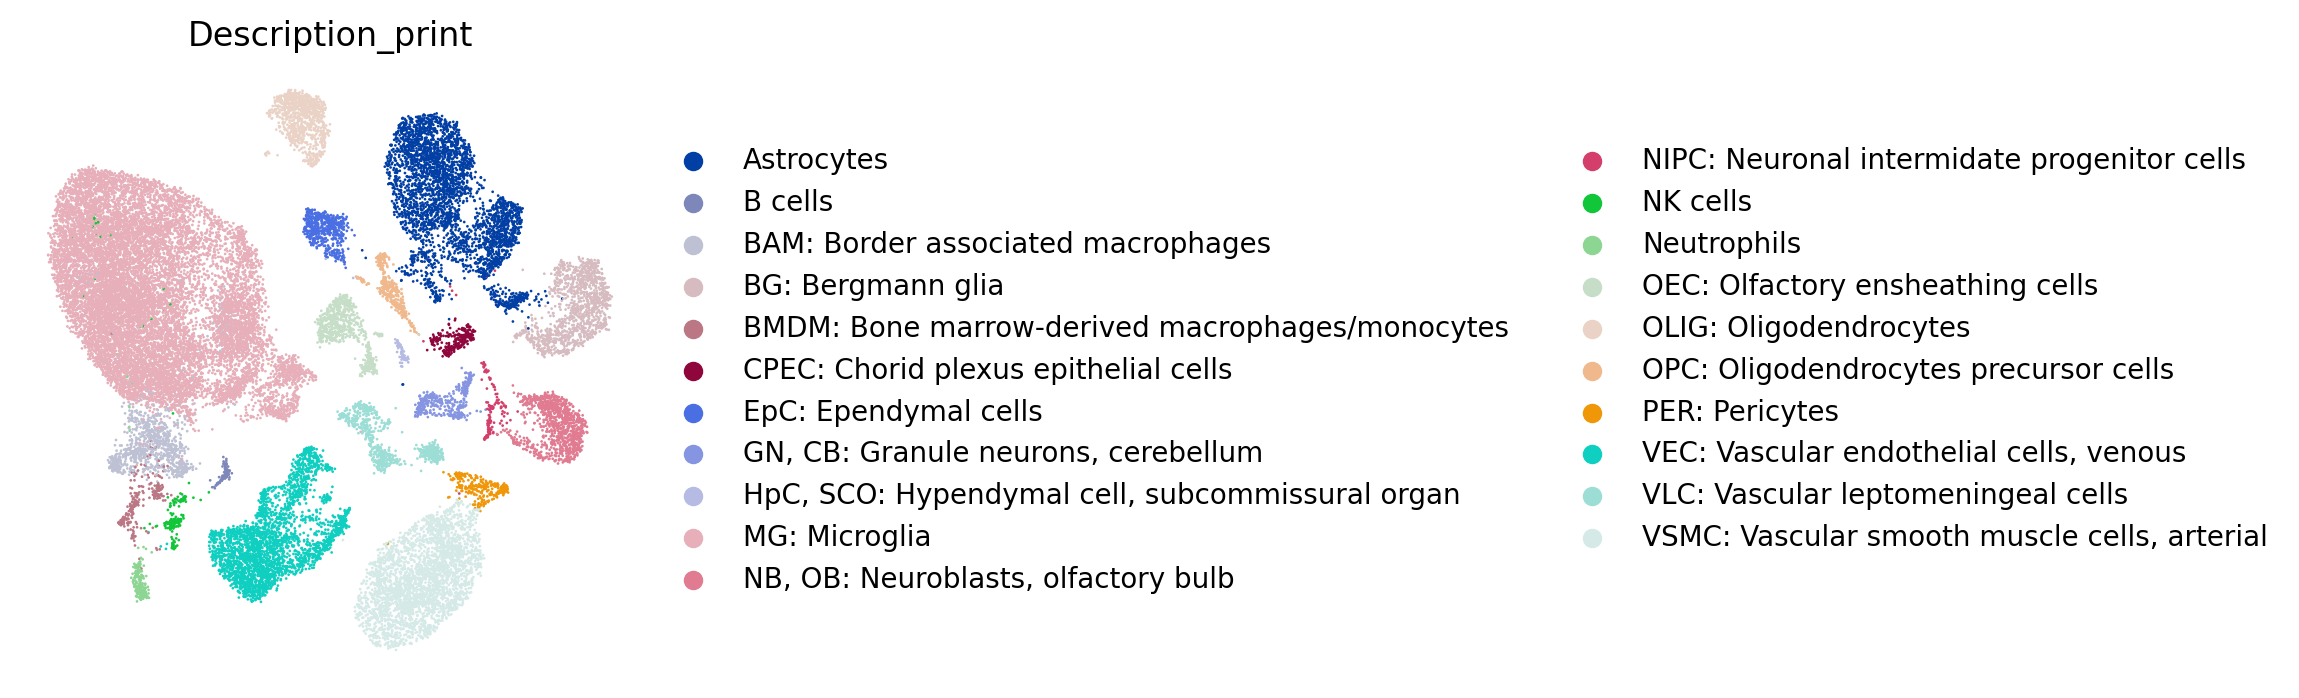

In [5]:
# Randomize the order of data points to plot
mpl.rcParams['figure.figsize'] = [4,4]
vis_rand = np.random.choice(range(adata.shape[0]),
                            replace=False, size=adata.shape[0])

sc.pl.umap(adata[vis_rand], 
           color=['Description_print'], frameon=False,
           legend_fontsize='medium')

## Marker gene expression

<b> Organize and consoliate marker gene lists </b>


Ensure the genes are detected in adata.

In [68]:
atlas_MarkerGenes_detect = {}

for p in adata.uns['annotation']['shared']:
    for c in adata.uns['annotation']['shared'][p].split('_'):
        if c!= 'unclear':
            atlas_MarkerGenes_detect[c] = atlas_MarkerGenes[c]

Integrate the manually annotated marker genes for infiltrating immune cells.

In [70]:
# B cells
atlas_MarkerGenes_detect['BC'] = ['CD19','MS4A1','CD79A'] 

# Border-associated macrophages
atlas_MarkerGenes_detect['BAM'] = ['MRC1', 'PF4', 'MS4A7', 'STAB1', 'CBR2']

# Bone marrow-derived macrophages
atlas_MarkerGenes_detect['BMDM'] = ['CCR2', 'ITGA4', 'ITGAL']

# NK cells
atlas_MarkerGenes_detect['NK'] = ['KLRK1','NCR1','NKG7'] 

# Neutrophils
atlas_MarkerGenes_detect['NEUT'] = ['CSF3R']

for k in atlas_MarkerGenes_detect.keys():
    atlas_MarkerGenes_detect[k] = np.intersect1d(atlas_MarkerGenes_detect[k], adata.var_names)

### Visualize expression of individual genes

Rows, annotated cell types in adata; columns, finalized marker genes from reference.

categories: Astrocytes, B cells, BAM, etc.
var_group_labels: OBNBL3, ACNT1, VECV, etc.


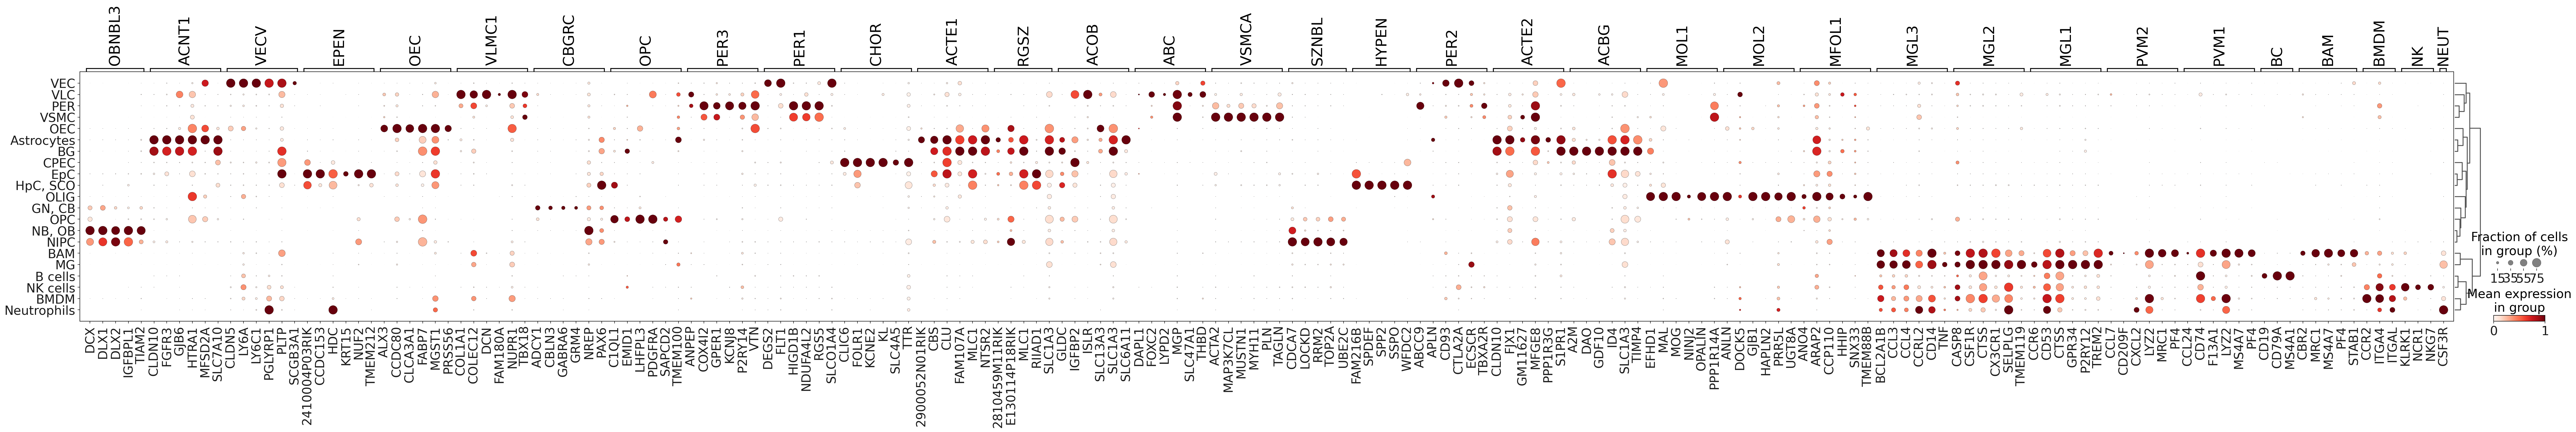

In [71]:
mpl.rcdefaults()
sc.set_figure_params(facecolor=None, fontsize=24)
sc.tl.dendrogram(adata, n_pcs=adata.uns['pca']['no_pcs'], groupby='Description_legend')

sc.pl.dotplot(adata,
              atlas_MarkerGenes_detect, 
              groupby='Description_legend', 
              dendrogram=True,
              standard_scale = 'var',
              dot_min = 0, dot_max =0.75)

### Quantify the total expression of markers for each reference cluster

Create abbreviations for cell type annotations for visualization.

In [76]:
def CreateObs(adata, obs, obs_list, obs_new, obs_list_new):
    ''''
    Create a new observation obs_new by matching the values from obs_list (of obs) to values in obs_list_new (provided in the corresponding order) 
    (e.g. Condition to Time or indexed Condition)
    '''
    adata.obs[obs_new] = obs_list_new[0]
    for i in np.arange(len(obs_list)):
        adata.obs[obs_new][adata.obs_names[adata.obs[obs] == obs_list[i]]] = obs_list_new[i]

In [75]:
obs = 'Description' # original observation to match from 
obs_list = np.unique([adata.uns['annotation']['Description'][a] \
                      for a in adata.uns['annotation']['shared']])
obs_list

array(['Astrocytes', 'B cells', 'Bergmann glia',
       'Bone marrow-derived macrophages/monocytes',
       'Border associated macrophages', 'Chorid plexus epithelial cells',
       'Ependymal cells', 'Granule neurons, cerebellum',
       'Hypendymal cell, subcommissural organ', 'Microglia', 'NK cells',
       'Neuroblasts, olfactory bulb',
       'Neuronal intermidate progenitor cells', 'Neutrophils',
       'Olfactory ensheathing cells', 'Oligodendrocytes',
       'Oligodendrocytes precursor cells', 'Pericytes',
       'Vascular endothelial cells, venous',
       'Vascular leptomeningeal cells',
       'Vascular smooth muscle cells, arterial'], dtype='<U41')

In [77]:
obs_new = 'Description_legend_abbre.' # new observation to match to
obs_list_new = ['ASTRO', 'BC', 'BG', # abbreviation terms listed in corresponding order
                'BMDM',
                'BAM', 'CPEC',
                'EpC', 'GN',
                'HpC', 'MG', 'NK',
                'NB',
                'NIPC', 'NEUT',
                'OEC', 'OLIG',
                'OPC', 'PER',
                'VEC',
                'VLC',
                'VSMC']
CreateObs(adata, obs, obs_list, obs_new, obs_list_new)

<b> Detection scores of the reference cell type markers </b>

In [78]:
# Dataframe for storing the expression detection scores 
CT_detect = pd.DataFrame(index = adata.obs['Description_legend_abbre.'].unique(),
                         columns = atlas_MarkerGenes_detect.keys())

In [79]:
# Expression status (binarized)
# if expressed: 1, if not expressed: 0
exp = pd.DataFrame((adata.X>0).astype(int),
                   index = adata.obs_names,
                   columns = adata.var_names)


# cellular detection
detect = adata.obs['n_genes_by_counts'] # Number of total genes detected 
frac = exp.div(detect, axis=0) # Detection normalized by the total number of genes detected

In [100]:
# Sum of binarized cellular detection statuses among all cells in a cluster in adata, normalized by the total number of cells and 
# then averaged between the marker genes
for p in CT_detect.index:

    p_cells =  adata.obs_names[adata.obs['Description_legend_abbre.'] == p]
    
    for c in CT_detect.columns:
        g = np.intersect1d(adata.var_names, atlas_MarkerGenes_detect[c])
        
        # Number of markers
        no = len(atlas_MarkerGenes_detect[c])  
        
        CT_detect.loc[p,c] = np.sum(np.sum(frac.loc[p_cells,g]))/p_cells.shape[0]/no

In [101]:
CT_detect.fillna(0, inplace=True)

In [102]:
CT_detect

OBNBL3         ACNT1          VECV          EPEN           OEC  \
OLIG   1.391914e-06  8.182406e-05  2.680036e-05  6.179398e-07  1.582845e-06   
BAM    6.649516e-07  8.309738e-07  6.295953e-05  1.733946e-06  1.065734e-05   
PER    3.533692e-07  2.644651e-05  3.923448e-05  1.303421e-06  2.041032e-05   
NIPC   2.004896e-04  2.077604e-05  5.928361e-06  2.316792e-05  5.646898e-05   
CPEC   1.383827e-06  3.062455e-05  6.402536e-05  4.392564e-05  1.744030e-05   
MG     9.109100e-08  3.717212e-07  8.345708e-06  2.124318e-06  5.171038e-06   
VEC    4.497366e-07  5.435724e-05  4.620087e-04  8.084014e-07  8.459494e-06   
BG     3.665207e-06  2.889518e-04  6.252378e-05  2.044747e-06  9.735043e-05   
NB     5.294318e-04  3.965418e-07  8.367448e-07  8.875707e-07  1.559953e-06   
BMDM   3.090767e-06  3.233379e-06  8.196867e-05  9.913532e-06  3.654739e-05   
NK     1.065951e-06  7.977019e-07  8.397529e-05  3.496885e-06  2.450689e-06   
VSMC   3.388270e-07  2.428062e-05  3.642270e-06  1.851687e-07  1.068336e-05   
EpC    6.719504e-06  4.507402e-05  6.371751e-05  2.781350e-04  8.354246e-05   
GN     1.255888e-04  5.773869e-06  3.638348e-06  4.338782e-07  7.958055e-07   
HpC    6.375240e-06  1.804084e-05  2.851566e-05  1.186291e-04  5.487640e-05   
ASTRO  7.079248e-06  4.028089e-04  1.509489e-05  3.006453e-06  9.707898e-05   
VLC    1.652386e-06  6.418213e-05  4.328638e-05  9.271328e-07  5.657588e-05   
OEC    2.211765e-06  1.209821e-04  6.578122e-05  8.730687e-07  3.165217e-04   
OPC    1.987654e-05  5.728231e-05  1.707541e-06  7.321132e-06  5.907257e-05   
BC     0.000000e+00  2.544918e-06  5.704426e-05  7.873520e-07  8.483059e-07   
NEUT   1.337292e-06  2.575244e-06  1.905604e-04  1.724313e-04  6.514844e-05   

              VLMC1         CBGRC           OPC          PER3          PER1  \
OLIG   1.572678e-06  1.942219e-06  2.682026e-06  9.306818e-07  9.410665e-07   
BAM    6.999273e-05  3.008429e-06  1.967553e-06  1.456784e-05  1.877470e-06   
PER    1.338681e-04  8.084731e-06  1.397713e-05  4.252654e-04  3.598249e-04   
NIPC   6.505588e-06  4.754249e-05  2.154905e-05  5.646391e-06  6.614647e-06   
CPEC   4.028542e-06  1.501951e-05  9.035511e-06  3.873325e-06  1.901699e-05   
MG     5.092117e-05  5.892483e-06  1.726999e-05  4.359504e-06  2.438695e-06   
VEC    5.035867e-06  9.757295e-06  3.150003e-06  1.093096e-05  2.547265e-04   
BG     2.298186e-05  2.765148e-05  2.845005e-05  3.661152e-06  1.407897e-06   
NB     1.876255e-06  1.094369e-04  1.047612e-06  1.229527e-06  2.182101e-06   
BMDM   6.965494e-05  3.534633e-06  1.179134e-06  1.211514e-05  1.124593e-05   
NK     1.203074e-05  9.250196e-07  1.457427e-05  1.529891e-05  6.161168e-06   
VSMC   5.776568e-05  1.164208e-05  1.718297e-05  1.717271e-04  2.056556e-04   
EpC    3.565210e-06  2.113408e-05  1.839483e-06  6.227052e-06  2.587538e-06   
GN     0.000000e+00  2.235362e-04  1.411834e-05  3.095073e-06  3.638272e-06   
HpC    6.217298e-06  6.727410e-05  3.200660e-05  1.068035e-05  6.395379e-06   
ASTRO  2.471126e-05  3.299540e-05  3.806304e-05  7.574054e-06  2.656677e-06   
VLC    2.692544e-04  1.725030e-05  6.032271e-05  1.011162e-04  3.034969e-05   
OEC    5.254816e-05  3.009948e-06  4.654597e-05  7.834663e-05  7.423372e-06   
OPC    8.221841e-07  1.920516e-05  1.771063e-04  5.124172e-06  1.369491e-05   
BC     5.811994e-06  2.464754e-06  5.421410e-06  9.363088e-06  1.446819e-05   
NEUT   8.976604e-06  1.488704e-06  8.119095e-07  1.716734e-06  1.183708e-05   

       ...          MGL3      MGL2          MGL1          PVM2          PVM1  \
OLIG   ...  1.598549e-06  0.000002  1.560068e-06  7.462275e-07  5.649049e-07   
BAM    ...  3.139779e-04  0.000387  3.205757e-04  2.916255e-04  3.817749e-04   
PER    ...  2.610733e-05  0.000019  1.036985e-05  3.972266e-06  1.315515e-06   
NIPC   ...  2.747548e-06  0.000013  9.205788e-06  6.843137e-07  1.525765e-06   
CPEC   ...  1.754708e-06  0.000016  2.789871e-06  5.462855e-07  1.375376e-06   
MG     ...  3.197317e-04  0.000457  4.355636e-04  6.768

In [103]:
adata.uns['MarkerGenes_detect_CTvisual'] = CT_detect

Rows, cell populations in adata; columns, reference cell types. 

In [155]:
sns.set_style("whitegrid")
h = sns.clustermap(adata.uns['MarkerGenes_detect_CTvisual'], 
                   standard_scale = 0, # Standardize between 0 and 1 per row
                   cmap='Reds', 
                   yticklabels=True, xticklabels=True, 
                   figsize= [14,10])

h.ax_heatmap.tick_params(left=False, bottom=True)

## Correlation of global transcriptome

### Process population-averaged transcriptome of our adata

Use the same set of relevant genes from adata, excluding mitochondrial genes, ribosomal genes, and MALAT1, while focusing on robustly detected genes.

In [124]:
adata_CT.var['relevant'] = adata.var['relevant']

To compute the correlation, focus on the union of highly expressed genes per cell type.

In [126]:
adata_CT.var['highExp'] = False

for p in adata_CT.obs_names:
    adata_CT.var['highExp'] = adata_CT.var['highExp']+ \
                                       (adata_CT[p].X.mean(0)>=1)
    
adata_CT.var['highExp'][~adata_CT.var['relevant']] = False

Log-transform the normalized UMI counts.

In [127]:
sc.pp.log1p(adata_CT, base=2)

### Process mouse brain atlas reference

Log-transform the provided UMI counts, using the relevant cell type references. Note that this atlas (built on healthy mouse brain tissue) does not contain infiltrated immune cells.

In [149]:
atlas_CT = atlas[list(atlas_MarkerGenes_detect.keys() - {'BC', 'BAM', 'BMDM', 'NK', 'NEUT'})].copy()
sc.pp.log1p(atlas_CT , base=2)

### Compute correlation

In [151]:
Corr = {} # Store as a directory, keys as the features used for computing correlation

for k in ['highExp']:
    genes_use = np.intersect1d(adata_CT.var_names[adata_CT.var[k]],
                               atlas_CT.var_names)
    
    Corr[k] = pd.DataFrame(index = adata_CT.obs_names,
                           columns = atlas_CT.obs_names)
    
    for p in Corr[k].index:
        for c in Corr[k].columns:
            Corr[k].loc[p,c] = np.corrcoef(adata_CT[p,genes_use].X, 
                                           atlas_CT[c,genes_use].X)[0,1]

In [153]:
# z-score per row
Corr_z = {}

for k in Corr.keys():
    s = Corr[k].astype(float).copy()
    Corr_z[k] = pd.DataFrame(sp.stats.zscore(s, axis=1),
                             index = s.index,
                             columns = s.columns)
    del s

In [154]:
adata.uns['CT_atlas_corr'] = Corr_z

### Visualize
Re-arrange the order of rows and columns to match that of the detection scores.

In [156]:
adata.uns['CT_atlas_corr_ordered'] = adata.uns['CT_atlas_corr'].copy()
adata.uns['CT_atlas_corr_ordered']['highExp'].loc[:, ['BC', 'BAM', 'BMDM', 'NK', 'NEUT']] = 0

In [157]:
adata.uns['CT_atlas_corr_ordered']['highExp']

ClusterName      MGL1      ACOB     CBGRC      CHOR      ACBG      MOL1  \
OLIG        -1.139760 -0.404533 -0.247080  0.172228 -0.117654  2.961647   
BAM          1.621154 -0.749660 -0.621187 -0.285516 -0.701357 -0.782949   
PER         -0.749261 -0.720570 -0.493307 -0.161824 -0.430567 -0.887257   
NIPC        -1.116263 -0.319866  0.399191  0.141023 -0.159285 -0.637390   
CPEC        -1.396162 -0.231099  0.675770  3.273792 -0.233630 -0.584012   
MG           2.075106 -0.676920 -0.669124 -0.301372 -0.655815 -0.769787   
VEC         -0.542175 -0.804061 -0.488013 -0.088275 -0.671697 -0.670177   
BG          -0.991452  1.765582 -0.652987 -0.097439  2.383959 -0.471417   
NB          -1.079404 -0.555573  1.107044  0.059757 -0.351144 -0.258732   
BMDM         1.335244 -0.998101 -0.543860 -0.268207 -0.859303 -0.858201   
NK           1.323454 -1.106739 -0.432351 -0.277267 -0.950201 -0.900110   
VSMC        -0.967878 -0.786468 -0.125818  0.095579 -0.537063 -0.718260   
EpC         -1.292113  0.445696 -0.349431  0.812848  0.558402 -0.853563   
GN          -1.353453 -0.093161  3.005450  0.586961  0.196521 -0.219074   
HpC         -1.180378 -0.153945  0.050374  0.940354 -0.012141 -0.842609   
ASTRO       -0.877178  1.940523 -0.589427 -0.051079  1.462138 -0.576030   
VLC         -0.819184 -0.514972 -0.798825  0.331477 -0.451490 -0.974509   
OEC         -1.229691  1.050247 -1.328271 -0.028682  0.921108 -0.395902   
OPC         -1.719521  0.336646  0.261719  0.074150  0.492827 -0.065002   
BC           0.969255 -1.234341 -0.146761 -0.247300 -1.024188 -0.919719   
NEUT         1.400873 -1.008425 -0.498368 -0.507249 -0.860979 -0.644356   

ClusterName      MGL2     VSMCA     ACNT1      RGSZ  ...    OBNBL3      PER3  \
OLIG        -0.905585 -0.641177 -0.671973  0.057295  ... -0.214636 -0.484196   
BAM          1.874556 -0.336417 -0.963944 -0.325513  ... -0.304618 -0.181877   
PER         -0.509235  2.210369 -0.936978 -0.245792  ... -0.248676  2.509694   
NIPC        -0.746456 -0.287407 -0.932028  0.568565  ...  2.366880 -0.073030   
CPEC        -1.168386 -0.081549 -0.866281  0.600953  ...  0.367905  0.061860   
MG           2.309152 -0.406629 -0.872782 -0.300622  ... -0.336487 -0.236418   
VEC         -0.308933  0.480719 -1.037606 -0.399678  ... -0.227722  0.879695   
BG          -0.969492 -0.809585  1.709577  1.405077  ... -0.668406 -0.486206   
NB          -0.767847 -0.212828 -1.173568  0.179358  ...  3.359155 -0.066013   
BMDM         1.727847 -0.011379 -1.298993 -0.421365  ... -0.054549  0.090594   
NK           1.769414  0.033118 -1.463422 -0.410169  ...  0.230154  0.104908   
VSMC        -0.598447  3.391237 -1.049148 -0.133826  ... -0.006799  1.666368   
EpC         -1.138792 -0.326467  0.068933  1.208692  ... -0.090272 -0.353850   
GN          -1.175727 -0.282943 -0.634530  0.395837  ...  2.227263 -0.108044   
HpC         -0.806006 -0.164505 -0.797475  0.834362  ...  0.415220 -0.161292   
ASTRO       -0.873176 -0.778599  1.964410  1.529118  ... -0.647090 -0.582658   
VLC         -0.526653  0.716072 -0.793688  0.041849  ... -0.431496  1.042453   
OEC         -1.080020 -0.816856  0.680377  1.342942  ... -0.871145 -0.240075   
OPC         -1.330201 -0.608761 -0.433909  0.772462  ...  1.414003 -0.327040   
BC           1.507351  0.096785 -1.639459 -0.375564  ...  0.543131  0.244469   
NEUT         1.882057 -0.040583 -1.210579 -0.486801  ... -0.272120  0.127441   

ClusterName       OEC     ACTE2      VECV   BC  BAM  BMDM   NK  NEUT  
OLIG         0.198591 -0.575877 -0.401757  0.0  0.0   0.0  0.0   0.0  
BAM         -0.408988 -0.942221  0.190531  0.0  0.0   0.0  0.0   0.0  
PER         -0.138943 -0.863115  0.853486  0.0  0.0   0.0  0.0   0.0  
NIPC        -0.034438 -0.559291 -0.087335  0.0  0.0   0.0  0.0   0.0  
CPEC        -0.172505 -0.615276  0.313468  0.0  0.0   0.0  0.0   0.0  
MG          -0.435060 -0.884258  0.123542  0.0  0.0   0.0  0.0   0.0  
VEC         -0.291259 -0.944837  2.727576  0.0  0.0   0.0  0.0   0.0  
BG           0.51473

In [158]:
CT_ordered = adata.uns['MarkerGenes_detect_CTvisual'].index[h.dendrogram_row.reordered_ind]
CT_ordered

Index(['BAM', 'BC', 'BMDM', 'NK', 'MG', 'NEUT', 'OLIG', 'BG', 'ASTRO', 'VEC',
       'PER', 'VSMC', 'NIPC', 'NB', 'GN', 'CPEC', 'EpC', 'HpC', 'VLC', 'OEC',
       'OPC'],
      dtype='object')

In [159]:
atlas_cluster_ordered = \
adata.uns['MarkerGenes_detect_CTvisual'].columns[h.dendrogram_col.reordered_ind]
atlas_cluster_ordered

Index(['BMDM', 'NK', 'NEUT', 'PVM1', 'PVM2', 'BAM', 'MGL2', 'MGL3', 'MGL1',
       'CBGRC', 'OBNBL3', 'SZNBL', 'OEC', 'ACOB', 'ACNT1', 'ACTE2', 'RGSZ',
       'ACTE1', 'ACBG', 'BC', 'CHOR', 'EPEN', 'HYPEN', 'VECV', 'VLMC1',
       'VSMCA', 'ABC', 'PER2', 'PER3', 'PER1', 'OPC', 'MFOL1', 'MOL1', 'MOL2'],
      dtype='object')

In [162]:
adata.uns['CT_atlas_corr_ordered']['highExp'] = \
adata.uns['CT_atlas_corr_ordered']['highExp'].loc[CT_ordered,:].loc[:,atlas_cluster_ordered]

adata.uns['CT_atlas_corr_ordered']['highExp'].astype(float)

BMDM   NK  NEUT      PVM1      PVM2  BAM      MGL2      MGL3      MGL1  \
BAM     0.0  0.0   0.0  2.144191  2.315256  0.0  1.874556  2.051342  1.621154   
BC      0.0  0.0   0.0  1.433712  1.551308  0.0  1.507351  1.623900  0.969255   
BMDM    0.0  0.0   0.0  1.864852  2.011248  0.0  1.727847  1.930677  1.335244   
NK      0.0  0.0   0.0  1.467608  1.575397  0.0  1.769414  1.966529  1.323454   
MG      0.0  0.0   0.0  1.580475  1.755943  0.0  2.309152  2.426964  2.075106   
NEUT    0.0  0.0   0.0  1.841639  2.138010  0.0  1.882057  2.190213  1.400873   
OLIG    0.0  0.0   0.0 -0.526622 -0.660768  0.0 -0.905585 -0.889006 -1.139760   
BG      0.0  0.0   0.0 -0.814528 -0.934268  0.0 -0.969492 -1.006923 -0.991452   
ASTRO   0.0  0.0   0.0 -0.805649 -0.884862  0.0 -0.873176 -0.905547 -0.877178   
VEC     0.0  0.0   0.0 -0.108484 -0.151084  0.0 -0.308933 -0.305267 -0.542175   
PER     0.0  0.0   0.0 -0.288904 -0.319405  0.0 -0.509235 -0.492804 -0.749261   
VSMC    0.0  0.0   0.0 -0.480673 -0.450517  0.0 -0.598447 -0.576303 -0.967878   
NIPC    0.0  0.0   0.0 -0.576108 -0.696426  0.0 -0.746456 -0.773365 -1.116263   
NB      0.0  0.0   0.0 -0.628712 -0.771984  0.0 -0.767847 -0.830258 -1.079404   
GN      0.0  0.0   0.0 -0.914898 -1.128390  0.0 -1.175727 -1.307564 -1.353453   
CPEC    0.0  0.0   0.0 -0.299372 -0.665623  0.0 -1.168386 -1.185273 -1.396162   
EpC     0.0  0.0   0.0 -0.755270 -0.906744  0.0 -1.138792 -1.149639 -1.292113   
HpC     0.0  0.0   0.0 -0.749193 -0.740595  0.0 -0.806006 -0.834865 -1.180378   
VLC     0.0  0.0   0.0 -0.158539 -0.082695  0.0 -0.526653 -0.444430 -0.819184   
OEC     0.0  0.0   0.0 -0.750170 -0.827585  0.0 -1.080020 -1.080312 -1.229691   
OPC     0.0  0.0   0.0 -1.083643 -1.303064  0.0 -1.330201 -1.345224 -1.719521   

          CBGRC  ...     VLMC1     VSMCA       ABC      PER2      PER3  \
BAM   -0.621187  ...  0.050745 -0.336417  0.429111  0.186843 -0.181877   
BC    -0.146761  ...  0.128166  0.096785  0.711976  0.932655  0.244469   
BMDM  -0.543860  ...  0.115522 -0.011379  0.625914  0.666857  0.090594   
NK    -0.432351  ...  0.140264  0.033118  0.703255  0.832594  0.104908   
MG    -0.669124  ... -0.076270 -0.406629  0.298732  0.142363 -0.236418   
NEUT  -0.498368  ...  0.061979 -0.040583  0.427201  0.546368  0.127441   
OLIG  -0.247080  ... -0.145784 -0.641177  0.294849 -0.327245 -0.484196   
BG    -0.652987  ... -0.287219 -0.809585 -0.097531 -0.615294 -0.486206   
ASTRO -0.589427  ... -0.275925 -0.778599 -0.061793 -0.675116 -0.582658   
VEC   -0.488013  ...  0.476424  0.480719  0.743337  2.441641  0.879695   
PER   -0.493307  ...  1.299802  2.210369  0.984159  1.708906  2.509694   
VSMC  -0.125818  ...  0.624424  3.391237  1.084863  1.356183  1.666368   
NIPC   0.399191  ... -0.074555 -0.287407  0.368046  0.186588 -0.073030   
NB     1.107044  ... -0.122166 -0.212828  0.208882  0.215686 -0.066013   
GN     3.005450  ... -0.355163 -0.282943  0.158268 -0.187631 -0.108044   
CPEC   0.675770  ...  0.255292 -0.081549  1.258209  0.398491  0.061860   
EpC   -0.349431  ... -0.165084 -0.326467  0.482363 -0.236255 -0.353850   
HpC    0.050374  ... -0.038712 -0.164505  0.752112  0.064360 -0.161292   
VLC   -0.798825  ...  2.518060  0.716072  2.861326  1.098302  1.042453   
OEC   -1.328271  ...  0.659970 -0.816856  0.718712 -0.185941 -0.240075   
OPC    0.261719  ... -0.112179 -0.608761  0.399186  0.144215 -0.327040   

           PER1       OPC     MFOL1      MOL1      MOL2  
BAM    0.068834 -0.201716 -1.280891 -0.782949 -0.923272  
BC     0.716670  0.188374 -1.596563 -0.919719 -1.063109  
BMDM   0.485905 -0.166773 -1.433483 -0.858201 -0.985581  
NK     0.574786  0.059358 -1.530769 -0.900110 -1.041601  
MG     0.002740 -0.140597 -1.207026 -0.769787 -0.892527  
NEUT   0.426834 -0.445054 -1.038842 -0.644356 -0.747134  
OLIG  -0.392655  0.583397  2.434213  2.961647  2.791850  
BG    -0.619338  0.477692 -0.753322 -0.471417 -0.540191  
ASTRO -0.654011  0.390117 -0.746371 -0.576030 -0.623780  
VEC    2.594909

In [163]:
sns.clustermap(adata.uns['CT_atlas_corr_ordered']['highExp'].astype(float),
               cmap='RdBu_r', #linewidths=0.25, 
               row_cluster=False, col_cluster=False,
               yticklabels=True, xticklabels=True, 
               figsize=[14,10], vmin = -2, vmax=2)

# Save results

In [164]:
# Save udpated adata to the original directory

# Processed adata of individual cells 
for h5_file in Path(DATA_DIR+source).glob('*filtered.h5'):   
    adata.write(h5_file)
    # adata: Log-transformed, normalized data, filtered to exclude empty droplets or low-quality droplets 
    
# Corresponding cell type-averaged expression (matching adata)
for h5_file in Path(DATA_DIR+source).glob('*CT.h5'):   
    adata_CT.write(h5_file) 
    # adata: (NOT log-transformed) normalized data, averaged among cells from cell type (based on the finalized annotation)

... storing 'Description_legend_abbre.' as categorical
